# ModTox: Predict toxicology to CYP2C9 based on the docking results of active/inactive dataset over a Molecular Dynamics simulation

In [40]:
import os
import numpy as np
import modtox.ML.preprocess as Pre
import modtox.ML.postprocess as Post
import modtox.ML.model2 as model
from sklearn.model_selection import train_test_split

## Load active, inactives and docking data (docked with glide)

In [41]:
folder = "tests_2/data/"
sdf_active = os.path.join(folder, "actives.sdf")
sdf_inactive = os.path.join(folder, "inactives.sdf")
csv = os.path.join(folder, "glide_features.csv")

## Generate features, dropnans and filter unwanted columns

In [42]:
pre = Pre.ProcessorSDF(csv=csv, fp=False, descriptors=False, MACCS=True, columns=None)
print("Fit and tranform for preprocessor..")
X, y = pre.fit_transform(sdf_active=sdf_active, sdf_inactive=sdf_inactive)
print("Sanitazing...")
pre.sanitize(X, y)
print("Filtering features...")
pre.filter_features(X)

Fit and tranform for preprocessor..
tests_2/data/actives.sdf tests_2/data/inactives.sdf
Active, Inactive
114 114
Read Active, Read Inactive
114 114
Non Repited Active, Non Repited Inactive
114 114
Shape Dataset
228
	Building MACS Fingerprints
	Incorporating external data


/Users/nostrum/repos/modtox/modtox/ML/external_descriptors.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  df = pd.concat([df.ix[:i-1], null_line, df.ix[i:]]).reset_index(drop=True)


Sanitazing...
Filtering features...


(array([[[  0. ,   0. ,   1. , ..., -67. , -40.5,   9.8]],
 
        [[  0. ,   0. ,   1. , ...,   nan,   nan,   nan]],
 
        [[  0. ,   0. ,   0. , ..., -59.6, -41.4,   8.4]],
 
        ...,
 
        [[  0. ,   0. ,   0. , ...,   nan,   nan,   nan]],
 
        [[  0. ,   0. ,   1. , ..., -28.2, -30.5,  19.5]],
 
        [[  0. ,   0. ,   1. , ..., -13.7,  -9.6,   9.9]]]),
 ['rdkit_fingerprintMACS_1',
  'rdkit_fingerprintMACS_10',
  'rdkit_fingerprintMACS_100',
  'rdkit_fingerprintMACS_101',
  'rdkit_fingerprintMACS_102',
  'rdkit_fingerprintMACS_103',
  'rdkit_fingerprintMACS_104',
  'rdkit_fingerprintMACS_105',
  'rdkit_fingerprintMACS_106',
  'rdkit_fingerprintMACS_107',
  'rdkit_fingerprintMACS_108',
  'rdkit_fingerprintMACS_109',
  'rdkit_fingerprintMACS_11',
  'rdkit_fingerprintMACS_110',
  'rdkit_fingerprintMACS_111',
  'rdkit_fingerprintMACS_112',
  'rdkit_fingerprintMACS_113',
  'rdkit_fingerprintMACS_114',
  'rdkit_fingerprintMACS_115',
  'rdkit_fingerprintMACS_116',
  '

## Fit stack model

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
#fit model
Model = model.GenericModel(clf='stack', tpot=True)
print("Fitting model...")
Model.fit(X_train,y_train)

Fitting model...


Generation 1 - Current best internal CV score: 0.9362903225806452
Generation 2 - Current best internal CV score: 0.9362903225806452
Generation 3 - Current best internal CV score: 0.9433345552297165

Best pipeline: LogisticRegression(input_matrix, C=10.0, dual=False, penalty=l1)


Generation 1 - Current best internal CV score: 0.9749877810361681
Generation 2 - Current best internal CV score: 0.9749877810361681
Generation 3 - Current best internal CV score: 0.9749877810361681

Best pipeline: LogisticRegression(input_matrix, C=1.0, dual=False, penalty=l1)


Generation 1 - Current best internal CV score: 0.8989674975562073
Generation 2 - Current best internal CV score: 0.8989674975562073
Generation 3 - Current best internal CV score: 0.930241935483871

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=15)


Generation 1 - Current best internal CV score: 0.9491813294232649
Generation 2 - Current best internal CV score: 0.9491813294232649
Generation 3 - Current best internal CV score: 0.9491813294232649

Best pipeline: LogisticRegression(input_matrix, C=0.1, dual=False, penalty=l1)


Generation 1 - Current best internal CV score: 0.9177297165200391
Generation 2 - Current best internal CV score: 0.9177297165200391
Generation 3 - Current best internal CV score: 0.9495845552297165

Best pipeline: LogisticRegression(SelectPercentile(input_matrix, percentile=4), C=15.0, dual=False, penalty=l2)


Generation 1 - Current best internal CV score: 1.0
Generation 2 - Current best internal CV score: 1.0
Generation 3 - Current best internal CV score: 1.0

Best pipeline: LogisticRegression(input_matrix, C=15.0, dual=False, penalty=l1)


## Predict on test

In [45]:
#predict model
print("Predicting...")
y_pred = Model.predict(X_test, y_test) 

Predicting...
Loading models


## Analyse results

In [12]:
pp = Post.PostProcessor(X_test, y_test, Model.prediction_test, Model.predictions_proba_test, y_pred_test_clfs=Model.clf_results, x_train=X_train, y_true_train=y_train)

### Metrics

In [37]:
ROC = pp.ROC()

In [38]:
PR = pp.PR()

    P   N
P  29   3
N   4  33


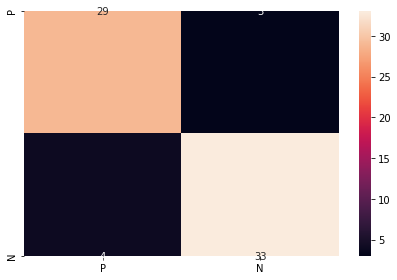

In [39]:
DA = pp.conf_matrix()

### Feature importance

In [24]:
SH = pp.shap_values(debug=True)

/Users/nostrum/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [21]:
FI = pp.feature_importance()

Extracting most importance features


### Uncertanties on predict

#### Descriptor distributions between test and train features.


  0%|          | 0/297 [00:00<?, ?it/s]/Users/nostrum/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/nostrum/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2

 26%|██▌       | 76/297 [00:09<00:28,  7.86it/s]

KeyboardInterrupt: 

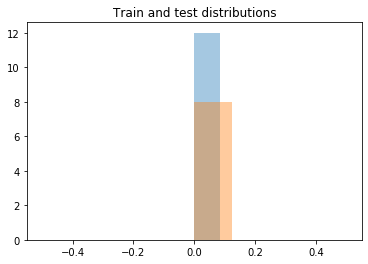

In [25]:
DD = pp.distributions()

#### Applicability domain of test samples

In [46]:
DA = pp.domain_analysis()

Computing applicability domains


IndexError: list index out of range

#### Uncertanty based on the results of the predictions of all classifiers

In [47]:
UN = pp.calculate_uncertanties()

AttributeError: 'list' object has no attribute 'any'

#### Dimensionanlity reduction

In [32]:
pp.UMAP_plot()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [33]:
pp.PCA_plot()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [34]:
pp.tsne_plot()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').